# Table of Contents
* [LIGO summer 2016 workbook](#LIGO-summer-2016-workbook)
* [2016-05-25 20:19:35, New terms & toy problem](#2016-05-25-20:19:35,-New-terms-&-toy-problem)
* [2016-05-26 07:33:57, Skyped Craig](#2016-05-26-07:33:57,-Skyped-Craig)
* [2016-06-16 10:16:30, Starting Literature Review](#2016-06-16-10:16:30,-Starting-Literature-Review)
* [2016-06-16 14:03:31 Toy Problem take #2](#2016-06-16-14:03:31-Toy-Problem-take-#2)
* [2016-06-20 12:10:07 Lit and links](#2016-06-20-12:10:07-Lit-and-links)
* [2016-06-24 09:47:18 Playing with parameter modeling code](#2016-06-24-09:47:18-Playing-with-parameter-modeling-code)
* [2016-06-27 09:06:19  More papers](#2016-06-27-09:06:19--More-papers)
* [2016-07-05 11:31:21 Toy problem for stacking observations](#2016-07-05-11:31:21-Toy-problem-for-stacking-observations)
* [2016-07-06 10:24:36 Expanding the toy problem](#2016-07-06-10:24:36-Expanding-the-toy-problem)


# LIGO summer 2016 workbook

Missy McIntosh

# 2016-05-25 20:19:35, New terms & toy problem

___

New Terms: 

- **ringdown** : longish-duration, small bandwidth waveform

- **matched filter analysis**

- **chirp mass**

- **Kerr configuration**

- **wave deforms length slightly, returning light is out of phase**

- **resonant optical cavity**

- **signal recycling mirror**: ?

___
Toy Problem:

- make sine gauss
- add gauss white noise w/ rand
- run mcmc have it tell me freq of the sine wave within it, and amplitude, width, time of peak

minimal uncertainty wavelengths gabor uncertainty

duration is width of peak

width of peak in frequency space = 1/ delta time

generate templates by stepping through parameter space

data * template in time domain and freqency domain

* more noise at low and high frequencies, colored noise,

divide by noise spectrum , optimal match fitting

time off = destructive interference, small product
freq wrong, etc, small number

peaked is best, but noise will screw results up
___

- **Sine-Gaussian waves** : sine wave signals modulated by a Gaussian envelope. These are characterized by the signal's central frequency and the ratio of central frequency to bandwidth (quality factor).

Well, ok. Here's a sine wave: 

$$y(t) = A\sin(2 \pi f t + \varphi) = A\sin(\omega t + \varphi)$$
where:

$A$ = the amplitude, the peak deviation of the function from zero.
$f$ = the ordinary frequency, the number of oscillations (cycles) that occur each second of time.
$\omega$ = $2\pi f$, the angular frequency, the rate of change of the function argument in units of radians per second
$\varphi$ = the phase, specifies (in radians) where in its cycle the oscillation is at $t = 0$.
When $\varphi$ is non-zero, the entire waveform appears to be shifted in time by the amount $\varphi/\omega$ seconds. A negative value represents a delay, and a positive value represents an advance.


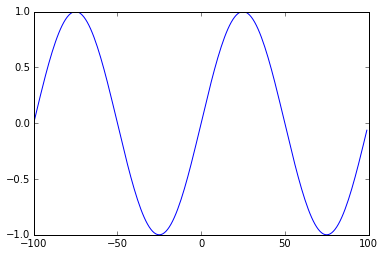

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gen_sine(amplitude,freq, sample_rate=100, phase=0):
    t = np.arange(-sample_rate,sample_rate)
    sinusoid = [amplitude*np.sin(2*np.pi*freq* (i/sample_rate)+ phase)  for i in t]
    return(t,sinusoid)

t,y = gen_sine(1,1)
plt.plot(t,y)
plt.show()

What's a sine-gaussian? Isn't that just like a wavepacket? 

Oh, look, Alan has a webpage on this stuff: https://labcit.ligo.caltech.edu/~ajw/bursts/burstsim.html

Which is conveniently depreciated. 

So it seems that Sine-Gaussian waves are of no astrophysical significance but can be used for "'swept-sine' calibration of our burst detection capability."

The waveforms that we are really interested in, those that might be from GW bursts are: 
- longish-duration, small bandwidth (ringdowns)
- longish-duration, large bandwidth (chirps)
- short duration, large bandwidth (merger)
- In-between (Zwerger-Muller or Dimmelmeier SN waveforms)

Anyway, the waveforms are:
- characterized by their frequency band, duration, and peak or root-sum-square amplitude
- in units of strain (that is, unitless)

And here's his Sine-Gaussian:
- h(t) = h0*exp(-(t-0.5).^2/tau^2).*sin(2*pi*f0*t); 
- My apologies for the historical use of tau instead of sigma_t = tau/sqrt(2).
- Peak amplitude h0 = 1.
- f0 = [100, 153, 235, 361, 554, 850, 1304, 2000]
- tau = 2/f0 (Q = sqrt(2)*pi*f0*tau = 8.88) or 
- tau = 2/3/f0 (Q = sqrt(2)*pi*f0*tau = 2.96)
- So, 8 central frequencies and 2 Q values = 16 waveforms

Okay, so it looks like: 

$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{\tau^2}} \sin(2\pi f_0 t) $$

or
$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

but I think using $\sigma_t$ is preferred because it makes the Q-value, $Q=\sqrt{2}\pi f_0 \tau$, into $Q=2\pi f_0 \sigma_t$.

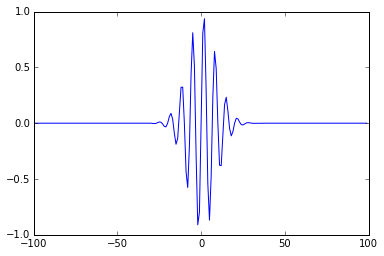

In [2]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)
plt.show()

Now for the white noise. 
- **white noise** : a random signal with a constant power spectral density;  a sequence of serially uncorrelated random variables with zero mean and finite variance; must be i.i.d.

Is drawing from random uniform ok? 

In [3]:
white_noise = np.random.uniform(-10,10,len(t))
np.var(white_noise)

31.973664809158105

Well. That isn't infinite. 

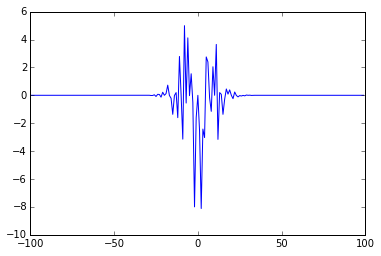

In [4]:
noisy_sinegauss = [s*n for s,n in zip(sinegauss, white_noise)]
plt.plot(t,noisy_sinegauss)
plt.show()

# 2016-05-26 07:33:57, Skyped Craig 

We went over control loop algebra and calibration and he gave me an ipython notebook for a toy problem he worked out.

This is the DARM (digital arm) spectrum: 

<img src="./figures/noise.png" style="width:700px;height:500px;">

and the quantum fluctuation/shot noise dominates at high frequencies, the seismic vibration (things like cars driving by) at low

<img src="./figures/block_diagram.png" style="width:700px;height:500px;"> 
Figure from \cite{abbott2016b}. 

We call the incoming signal $h(f) - a(f)$. 

\begin{align}
e(f) = & (h(f)-a(f))C(f)\\ 
-a(f) = & e(f)D(f)A(f)
\end{align}

combinded, we find:
    
\begin{align}
e(f) = & (h(f) - e(f)D(f)A(f))C(f) \\
e(f) = & h(f)C(f) - e(f)D(f)A(f)C(f) \\
e(f)(1+D(f)A(f)C(f)) = & h(f)C(f) \\
h(f) = & \frac{1+A(f)C(f)D(f)}{C(f)} e(f) \\
h(f) = & \frac{1 + G(f)}{C(f)} e(f)
\end{align}

where $G(f)$ is the open loop transfer function


here's his toy problem: 

https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
    
and he also said he would send me a code written by a grad student named Hill that has to do tracing errors in parameters that make up the $h(f) - a(f)$ signal

# 2016-06-16 10:16:30, Starting Literature Review

I'm reading \cite{abbott2016b} and \cite{Feedback2005}:

https://dcc.ligo.org/public/0122/P1500248/010/P1500248_EarlyaLIGOCalUncertainty.pdf
 
    
http://fraden.brandeis.edu/courses/phys39/Thermal%20Control/PID/Bechhoefer%20Feedback%20for%20physicists%20Rev%20Mod%20Phys%202005.pdf
    

# 2016-06-16 14:03:31 Toy Problem take #2

In [5]:
#Based off of Craig's code: https://gist.github.com/ccahilla/9b9738deb0bcf55155d2aba0058492c5
np.random.seed(123456789)   # repeatable results

def complex_sine_gaussian(central_time, central_freq, amplitude, phase, decay, time):
    return amplitude * np.exp(- decay * np.square(time - central_time)) * np.exp(1j*(2*np.pi*central_freq*(time - central_time) + phase))


So it looks like the equation for a complex sine Gaussian is: 

$$
Ae^{-d(t-t_c)^2}e^{2\pi f_c (t-t_c) + \phi}
$$

So maybe he used Euler's formula and rearranged?


\begin{aligned}e^{ix}&=\cos x+i\sin x\;\\e^{-ix}&=\cos(-x)+i\sin(-x)=\cos x-i\sin x\;\end{aligned}


$$ h(t) = h_0 e^{-\frac{(t-0.5)^2}{(2\sigma_t^2 )}} \sin(2\pi f_0 t) $$

Actually, I'm not sure. I will ask about that. 

The other change is to generate the white noise from a normal instead of uniform and to add instead of multiply it

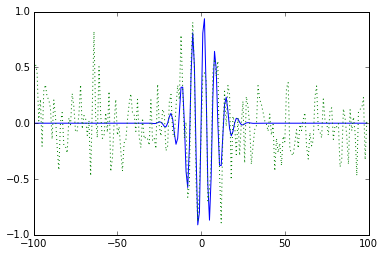

In [6]:
def gen_gaussian(t, sigma_t):
    gauss = [np.exp(-(i-0.5)**2/(2*sigma_t**2)) for i in t]
    return(t,gauss)
    
def gen_sinegauss(amplitude,freq, sigma_t, sample_rate=100, phase=0):
    t, sine = gen_sine(amplitude,freq,sample_rate, phase)
    t, gauss = gen_gaussian(t, sigma_t)
    sinegauss = [s*g for s,g in zip(sine, gauss)]
    return(t,sinegauss)

freq = 15
q = 800
sigma_t = q/(2*np.pi*freq)


t, sinegauss = gen_sinegauss(1,freq,sigma_t)
plt.plot(t,sinegauss)


white_noise = np.random.normal(0,0.25,len(t))
np.var(white_noise)

noisy_sinegauss = sinegauss+white_noise
plt.plot(t,noisy_sinegauss, ':')
plt.show()

In [7]:
# Slightly modified Craig's code:
Amp_signal = np.sqrt(np.mean(np.square(noisy_sinegauss)));
Amp_noise  = np.sqrt(np.mean(np.square(white_noise)));
SNR = np.square(Amp_signal/Amp_noise)
print('RMS Amplitude of the signal = ', Amp_signal)
print( 'RMS Amplitude of the noise = ', Amp_noise)
print( 'SNR = ', SNR)

RMS Amplitude of the signal =  0.286445655586
RMS Amplitude of the noise =  0.229769980285
SNR =  1.55416779626


Okay. Now time for the MCMC part. 

MCMCs are a way to generate statistical samples from probability distributions when integrating the probability distribution is too hard. They are a class of algorithms of which Metropolis-Hastings is the most popular (I think) but I use Goodman & Weare's algorithm in the emcee python package. 

burn in info:
http://users.stat.umn.edu/~geyer/mcmc/burn.html


In [8]:
# Craig's code again:
# Define Log Likelihood

uncs = noise_std * np.ones(len(t))  # Uniform uncertainty in each point
def lnprob(theta, t, signal, uncs) :
    tc = theta[0]
    fc = theta[1]
    amplitude = theta[2]
    phase = theta[3]
    a = theta[4]
    
#     a = b * fc**2
    if (tc < t[0] or t[-1] < tc or fc <= 0 or fc >= 0.5/(t[1]-t[0]) or 
        amplitude <= 0 or amplitude > 5.0 or phase < -np.pi or phase >= np.pi or a <= 0 or a > 150.0):
        return -np.inf
    else :
        new_signal = np.real(complex_sine_gaussian(tc, fc, amplitude, phase, a, t));
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

NameError: name 'noise_std' is not defined

# 2016-06-20 12:10:07 Lit and links



This paragraph from \cite{abbott2016b} seems to have information pertinent to my project purpose: 

"Though not yet the dominant source of error, based on the
expected sensitivity improvement of Advanced LIGO [32], calibration
uncertainties may limit astrophysical measurements
in future observing runs. In the coming era of numerous detections
of gravitational waves from diverse sources, accurate
estimation of source populations and properties will depend
critically on the accuracy of the calibrated detector outputs of
the advanced detector network. In the future, the calibration
physical model and its uncertainty will be directly employed
in the astrophysical parameter estimation procedure, which
will reduce the impact of this uncertainty on the estimation
of source parameters. We will continue to improve on the
calibration accuracy and precision reported here, with the goal
of ensuring that future astrophysical results are not limited by
calibration uncertainties as the detector sensitivity improves
and new sources are observed."

I was looking through http://www.ligo.org/ and I found these cool things: 

https://www.youtube.com/watch?v=KwbXxzgAObU

https://www.youtube.com/watch?v=3pK5oenm5gw

http://www.ligo.org/multimedia/gallery/opt.php

https://www.ligo.caltech.edu/gallery

http://www.gwoptics.org/

http://epo.sonoma.edu/EposChronicles/?p=3623&lang=en

https://www.youtube.com/channel/UCMATJmzibndbcdY8s9Prhjg

less interesting

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/115/

http://www.amnh.org/sciencebulletins/content/a.f.gravity.20041101/assets/114/

http://spaceplace.nasa.gov/ligo-g-waves/en/

Videos:
"LIGO: A passion for understanding"
"LIGO Generations"

I also found some digital signal processing stuff and looked up info on Binder

# 2016-06-24 09:47:18 Playing with parameter modeling code

In [ ]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
%matplotlib inline
#notebook
plt.rc('text', usetex=False)
plt.rcParams['mathtext.default']='regular'
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["font.size"] = 14.0

infiles = glob.glob('../data/*')
print(infiles)

Parameter list from /home/kent/lsc/master/bin/cbcBayesPostProc.py
massParams=['mtotal','m1','m2','mc']
    distParams=['distance','distMPC','dist']
    incParams=['iota','inclination','theta_jn']
    polParams=['psi','polarisation','polarization']
    skyParams=['ra','rightascension','declination','dec']
    timeParams=['time']
    spinParams=['spin1','spin2','a1','a2','a1z','a2z','phi1','theta1','phi2','theta2',
    'chi','effectivespin','chi_eff','chi_tot','chi_p','beta','tilt1','tilt2','phi_jl','theta_jn','phi12']
    sourceParams=['m1_source','m2_source','mtotal_source','mc_source','redshift']
intrinsicParams=massParams+spinParams
    extrinsicParams=incParams+distParams+polParams+skyParams
    sourceFrameParams=sourceParams+distParams

In [ ]:

df = pd.read_csv(infiles[0], sep='\t')
df.columns = df.columns.str.replace('Unnamed: 0','name')
print(df.name.values)
parameters = ['redshift','distance', 'mtotal', 'mc','matched_filter_snr', 'ra', 'dec', 'q', 'eta','psi','cosiota']
statistics = df.columns.values[1:-3]
statistics = [s for s in statistics if s != 'KL']

In [ ]:

def plotparams(parameter, statistic, ax, log=False):
    
    neffs = []
    values = []
    people = []
    for file in infiles: 
        neff = file.split('neff')[1].split(".dat")[0]
        
        try:
            neff = float(neff)
            person = 'm'
        except:
            try:
                person = neff[-1]
                neff = float(neff[:-1])
            except:
                person = neff[-2]
                neff = float(neff[:-2])
            
        df = pd.read_csv(file, sep='\t')
        value = df.loc[df['Unnamed: 0'] == (parameter)][statistic].values[0]
        neffs.append(neff)
        values.append(value)
        people.append(person)
    try:
        #fig = plt.figure(figsize=(10,5))
        #ax = fig.add_subplot(111)
        colordict = {'m':'r', 'k':'b'}
        plt.title('{0}'.format(statistic, parameter))
        if log:
            for i in np.arange(len(values)):
                plt.scatter(np.log10(values[i]), np.log10(neffs[i]), color=colordict[people[i]], label=people[i])
            plt.xlabel(r'$log_{10}$'+'{0}'.format(parameter))
            plt.ylabel(r'$log_{10}n_{eff}$')
        else:
            for i in np.arange(len(values)):
                plt.scatter(values[i], neffs[i], color=colordict[people[i]], label=people[i])
            plt.xlabel('{0}'.format(parameter))
            plt.ylabel(r'$n_{eff}$')
            
        handles, labels = ax.get_legend_handles_labels()
        display = (0,1)
        
        #ax.legend([handle for i,handle in enumerate(handles) if i in display],
        #      ['kent', 'missy'])
        #plt.show()
              
    except:
        print('issue with {0}, {1}'.format(parameter, statistic))

In [ ]:
for parameter in parameters:
        fig = plt.figure()
        fig.suptitle(' '*50+'{0}'.format(parameter), size=20, y=1.08)
        gs = gridspec.GridSpec(1, len(statistics))
        gs.update(wspace=0.001)
        for i,statistic in enumerate(statistics): 
            if i == 0: 
                ax = plt.subplot(gs[0, i])
            else:
                ax = plt.subplot(gs[0, i], sharey=ax)
                plt.setp(ax.get_yticklabels(), visible=False)
                plt.setp(ax.yaxis.get_label(), visible=False)
            plotparams(parameter, statistic, ax)
            plt.setp(ax.get_xticklabels(), rotation=45)

        gs.tight_layout(fig, rect=[0, 0, 2, 1])
        plt.show()


In [ ]:
matplotlib.pyplot.close("all")

# 2016-06-27 09:06:19  More papers

Here's some reference having to do with the actual LIGO instrument

http://adsabs.harvard.edu/abs/1995OptL...20.1507R
http://www.sciencedirect.com/science/article/pii/037596019390620F
http://www.sciencedirect.com/science/article/pii/037596019390620F

And then Allen gave me a few on testing GR:
https://dcc.ligo.org/public/0122/P1500213/031/paper.pdf
https://dcc.ligo.org/public/0122/P1500218/014/PhysRevLett.116.241102.pdf
https://dcc.ligo.org/public/0124/P1600088/016/bbh-o1.pdf

and TIGER:
http://arxiv.org/pdf/1311.0420v2.pdf

Alan said he would rather me not go into depth about the code/how mcmc works but just say what they do

# 2016-07-05 11:31:21 Toy problem for stacking observations

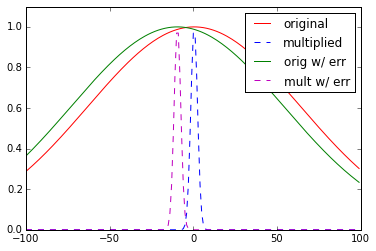

In [87]:
# generate gaussian with some width, multiply a few of them to see if the peak narrows 

freq = 0.1
q = 10*4
sigma_t = q/(2*np.pi*freq)
sample_rate = 100
t = np.arange(-sample_rate,sample_rate)


t, gauss = gen_gaussian(t,sigma_t)
n = 10**3
multgauss = [g**n for g in gauss]
plt.plot(t,gauss, 'r', label="original")
plt.plot(t,multgauss, 'b', linestyle = "--",label="multiplied")

# add a deliberate systematic error, multiply a few to see if the peak will not narrow
err = -10
_, err_gauss = gen_gaussian([i-err for i in t],sigma_t)
err_multgauss = [g**n for g in err_gauss]
plt.plot(t, err_gauss, 'g', label="orig w/ err")
plt.plot(t, err_multgauss, 'm', linestyle = "--",label="mult w/ err")
plt.ylim(0,1.1)

plt.legend()
plt.show()

# yep

# 2016-07-06 10:24:36 Expanding the toy problem

In [1]:
import os 
import sys
path = '/Users/mmcintosh/GoogleDrive/LIGO/tutorials/GW150914_tutorial'
sys.path.insert(0, path)
os.chdir(path)


In [2]:
# Get the boxing day template and matched filter engine from losc event tutorial, 
# https://losc.ligo.org/s/events/GW151226/LOSC_Event_tutorial_GW151226.html
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
# I used python-modernize on this so it works with 3.4
import readligo

eventname = 'GW151226' 


In [3]:
# Read the event properties from a local json file
fnjson = "O1_events.json"
events = json.load(open(fnjson,"r"))

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)


Reading in parameters for event GW151226
{'fn_template': 'GW151226_4_template.hdf5', 'a2': -0.0396, 'a1': 0.3998, 'fn_H1': 'H-H1_LOSC_4_V1-1135136334-32.hdf5', 'utcevent': '2015-12-26T03:38:53.65', 'fs': 4096, 'tevent': 1135136350.65, 'URL': 'https://losc.ligo.org/s/events/GW151226/', 'fband': [43.0, 800.0], 'f_min': 10.0, 'm2': 6.7054, 'm1': 19.6427, 'name': 'GW151226', 'fn_L1': 'L-L1_LOSC_4_V1-1135136334-32.hdf5', 'approx': 'lalsim.SEOBNRv2'}


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


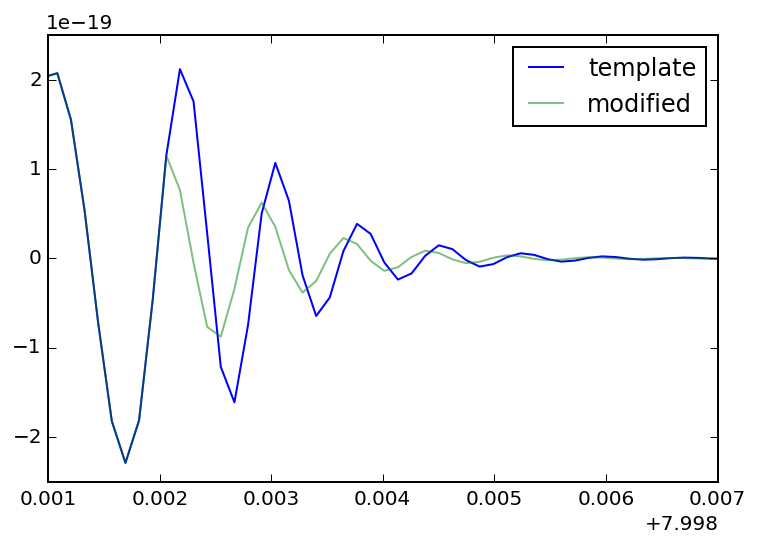

recovered parameters 0.5 1.0471975512
original parameters 0.5 1.0471975511965976


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in true_divide


In [342]:

# get the template
f_template = h5py.File(fn_template, "r")
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.
time = np.linspace(0,16, len(template_p))
dt = time[1] - time[0]

GRtemplate = (template_p + template_c*1.j) 







import cmath as c
def shiftphase(rectangular_coords, phase_shift):
    r, phi = c.polar(rectangular_coords)
    shifted_phi = phi + phase_shift
    shifted_rectangular = c.rect(r,shifted_phi)
    return(shifted_rectangular)
def modifyringdown(template,amplitude,phase):
    max_index = np.argmax(template)
    mod_ringdown = [shiftphase(x,phase)*amp for x in GRtemplate[max_index:]]
    mod_template = np.concatenate([template[:max_index],mod_ringdown])
    return(mod_template)

amp = 0.5
phase = np.pi/3
mod_template = modifyringdown(GRtemplate,amp,phase)

plt.plot(time, GRtemplate, label="template")
plt.plot(time,mod_template, alpha=0.5,label="modified")
plt.ylim(-2.5*scale,2.5*scale)
plt.xlim(7.999,8.005)
plt.legend(loc=0)
plt.show()

# recover the parameters
max_index = np.argmax(GRtemplate)
difference = (mod_template[max_index:]/GRtemplate[max_index:])
amps, phases = zip(*[c.polar(d) for d in difference])
print('recovered parameters',np.nanmean(amps), np.nanmean(phases))
print('original parameters',amp, phase)


In [238]:
def matchfiltering(template, data):
            '''

            plt.plot(time, template, label="template")
            plt.plot(time,data, '.', alpha= 0.05, label="data")

            plt.ylim(-2.5*scale,2.5*scale)
            plt.xlim(0,10)
            plt.legend(loc=0)
            plt.show()
            '''
            # -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
            #   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
            NFFT = 4*fs
            psd_window = np.blackman(NFFT)
            # and a 50% overlap:
            NOVL = NFFT/2


            # We will record the time where the data match the END of the template.
            etime = time+template_offset
            # the length and sampling rate of the template MUST match that of the data.
            datafreq = np.fft.fftfreq(template.size)*fs
            df = np.abs(datafreq[1] - datafreq[0])

            # to remove effects at the beginning and end of the data stretch, window the data
            # https://en.wikipedia.org/wiki/Window_function#Tukey_window
            try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
            except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

            # prepare the template fft.
            template_fft = np.fft.fft(template*dwindow) / fs


            # -- Calculate the PSD of the data.  Also use an overlap, and window:
            data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

            # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
            data_fft = np.fft.fft(data*dwindow) / fs

            # -- Interpolate to get the PSD values at the needed frequencies
            power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

            # -- Calculate the matched filter output in the time domain:
            # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
            # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
            # so the result will be plotted as a function of time off-set between the template and the data:
            optimal = data_fft * template_fft.conjugate() / power_vec
            optimal_time = 2*np.fft.ifft(optimal)*fs

            # -- Normalize the matched filter output:
            # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
            # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
            sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
            sigma = np.sqrt(np.abs(sigmasq))
            SNR_complex = optimal_time/sigma

            # shift the SNR vector by the template length so that the peak is at the END of the template
            peaksample = int(data.size / 2)  # location of peak in the template
            SNR_complex = np.roll(SNR_complex,peaksample)
            SNR = abs(SNR_complex)

            # find the time and SNR value at maximum:
            indmax = np.argmax(SNR)
            timemax = time[indmax]
            SNRmax = SNR[indmax]

            # Calculate the "effective distance" (see FINDCHIRP paper for definition)
            # d_eff = (8. / SNRmax)*D_thresh
            d_eff = sigma / SNRmax
            # -- Calculate optimal horizon distnace
            horizon = sigma/8

            # Extract time offset and phase at peak
            phase = np.angle(SNR_complex[indmax])
            offset = (indmax-peaksample)
            #print offset

            # apply time offset, phase, and d_eff to whitened template, for plotting
            #template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
            template_whitened = template
            template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
            template_match = np.roll(template_phaseshifted,offset) / d_eff

            #strain_whitenbp = filtfilt(bb, ab, whiten(strain_L1,psd_L1,dt)
            
            return(SNRmax)

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


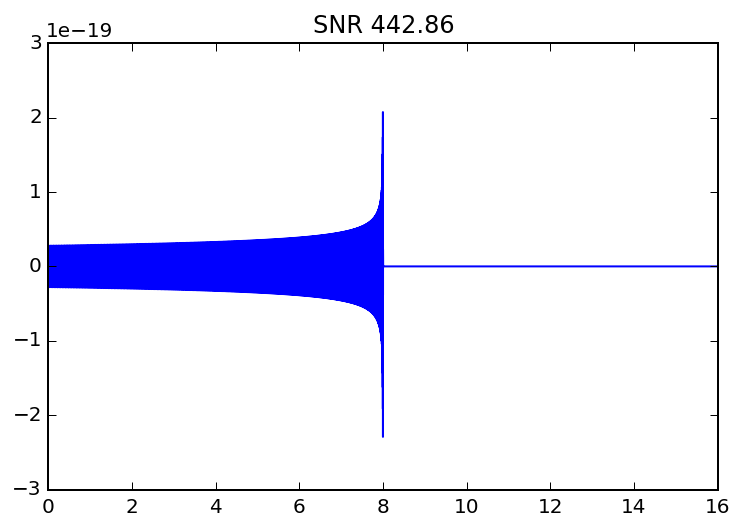

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in true_divide


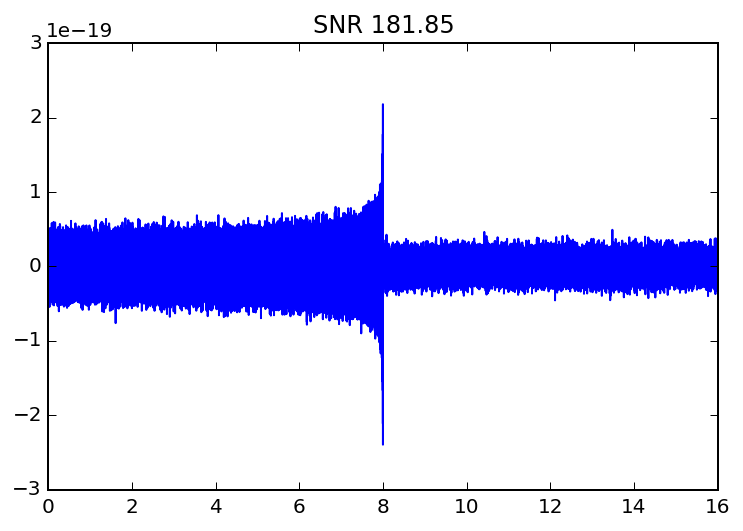

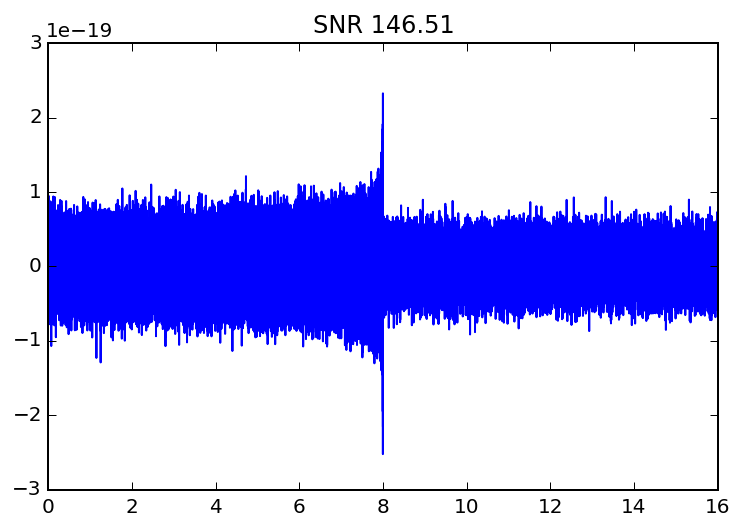

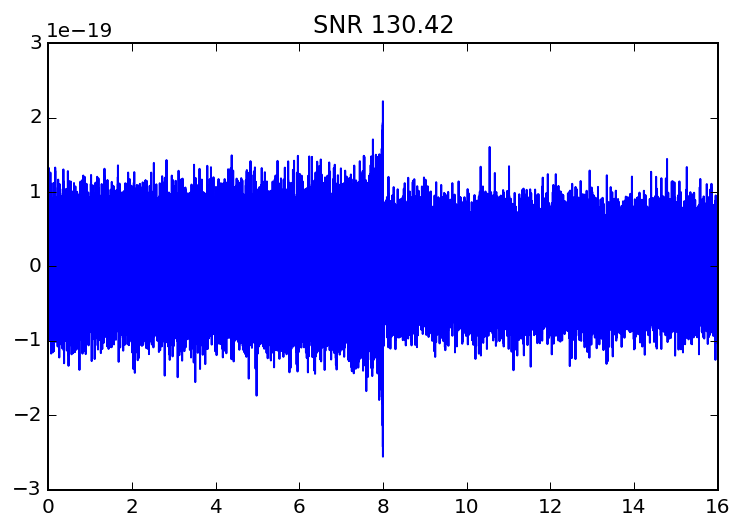

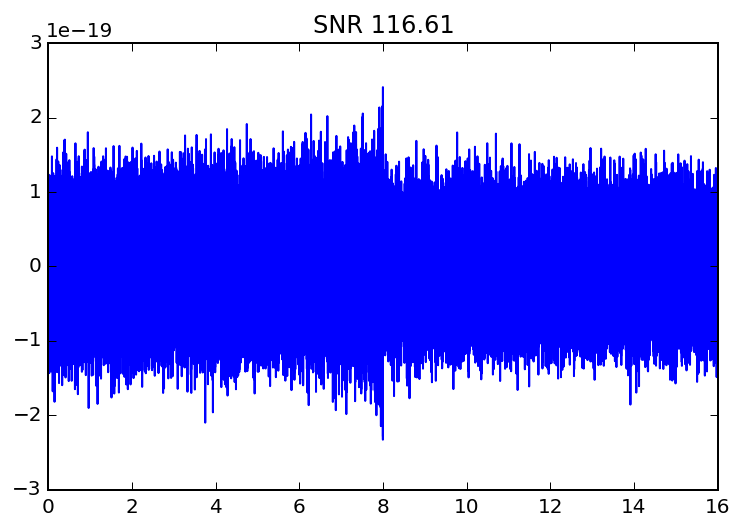

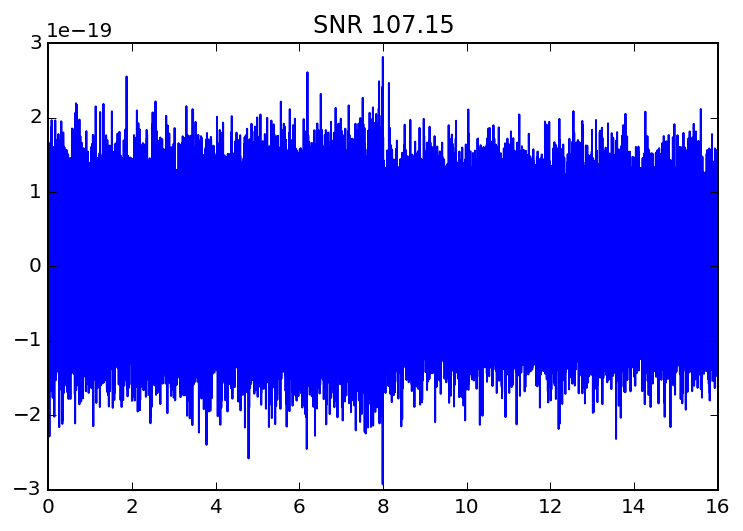

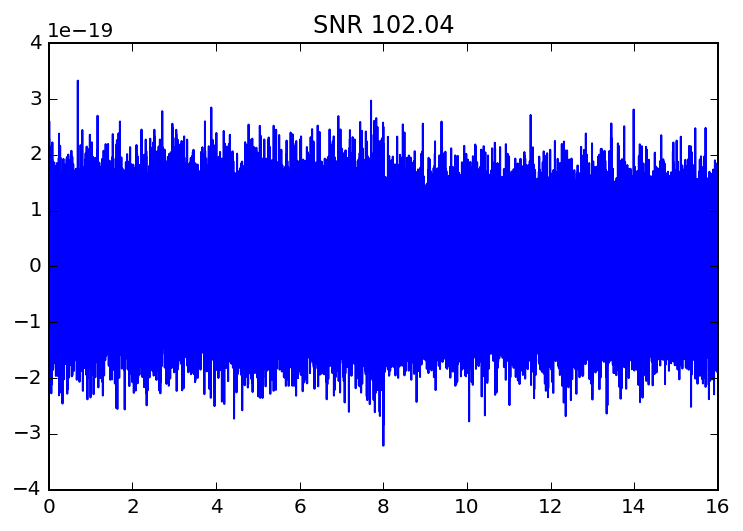

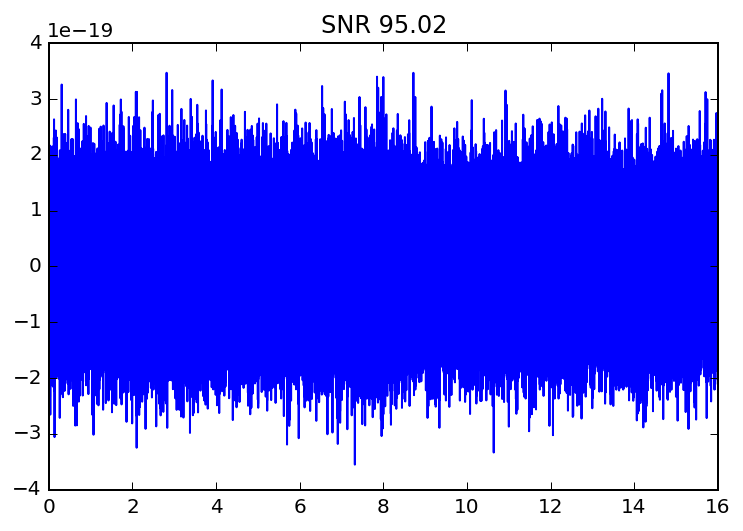

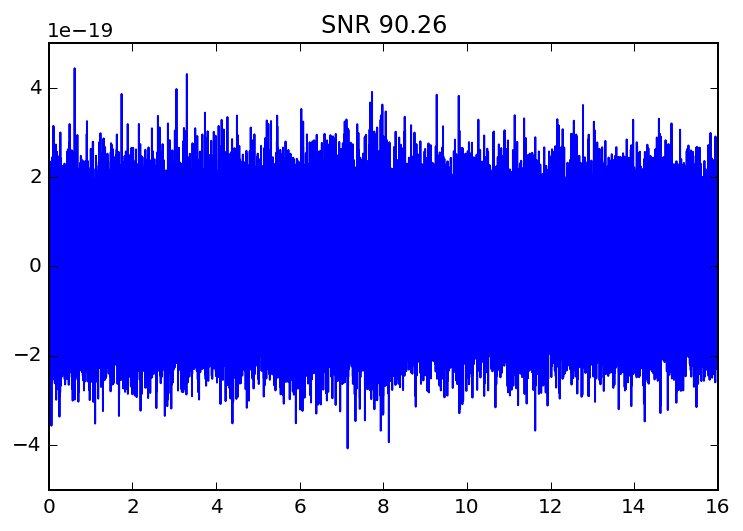

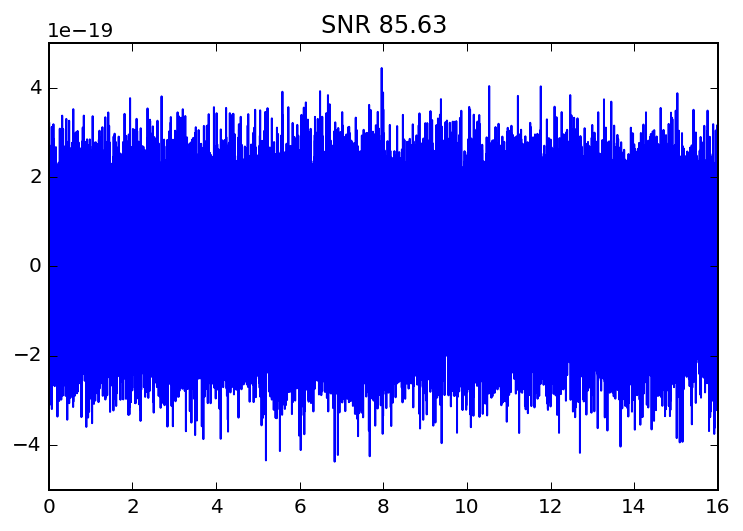

In [415]:
def withnoise(template1, template2, noise_levels, plot=False):
    snr_arr = []
    ramp = []
    rphase = []

    for i in noise_levels:
        if i==0:
            data = template2.copy()
        else:    
            # add gaussian noise to template to make some data
            # take PSD of white noise & see where it lies compared to true PSD of LIGO
            # check where you start frequency & see how results depend on it
            scale = 10**-19
            white_noise = np.random.normal(0,i,len(template1))
            data = template1.copy() + white_noise*scale
            
        SNRmax = matchfiltering(template2, data)
        snr_arr.append(SNRmax)
        
        # recover the parameters
        max_index = np.argmax(template2)
        difference = (data[max_index:]/template2[max_index:])
        amps, phases = zip(*[c.polar(d) for d in difference])
        amps = np.asarray(amps)
        amps = amps[~np.isnan(amps)]
        amps = amps[np.isfinite(amps)]
        phases = np.asarray(phases)
        phases = phases[~np.isnan(phases)]
        phases = phases[np.isfinite(phases)]
        ramp.append(amps)
        rphase.append(phases)
        if plot: 
            plt.title('SNR {0:.2f}'.format(SNRmax))
            plt.plot(time, data)
            plt.show()
    return(snr_arr,ramp,rphase)
     
noise_levels = np.linspace(0,1,10)
modmod_snr_arr,modmodr_amps,modmodr_phases = withnoise(both_ringdown, both_ringdown, noise_levels, plot=True)
modGR_snr_arr,modGRr_amps,modGRr_phases = withnoise(both_ringdown, GRtemplate, noise_levels)
GRGR_snr_arr,GRGRr_amps,GRGRr_phases = withnoise(GRtemplate, GRtemplate, noise_levels)
 
 

In [400]:
modmodr_amps[1]

array([  9.97338528e-01,   1.04748636e+00,   1.01402426e+00,
         1.00008012e+00,   1.05690846e+00,   9.60682230e-01,
         1.02803171e+00,   1.00386170e+00,   1.04009672e+00,
         1.01962873e+00,   1.00001397e+00,   8.96397880e-01,
         1.09431970e+00,   1.00060817e+00,   1.13304698e+00,
         7.34395708e-01,   8.61516817e-01,   1.08741104e+00,
         6.24905813e-01,   1.21937588e+00,   1.09779147e+00,
         1.05200805e+00,   1.24286597e+00,   1.03601471e+00,
         8.41063139e-01,   6.31008709e-01,   1.20659715e+00,
         1.67253309e+00,   7.74797107e-01,   1.83748454e+00,
         2.40432946e+00,   7.20282812e-01,   1.27462123e+00,
         1.70351787e+00,   7.39439719e-01,   5.30569972e+00,
         2.47023629e+00,   2.62030993e+00,   1.35286180e+01,
         3.64325320e+00,   6.96612564e+00,   3.07073051e+00,
         4.34038422e+00,   2.36600959e+00,   1.71325256e+01,
         7.15898974e+00,   1.85934961e+00,   4.94597580e+01,
         2.52916629e+01,

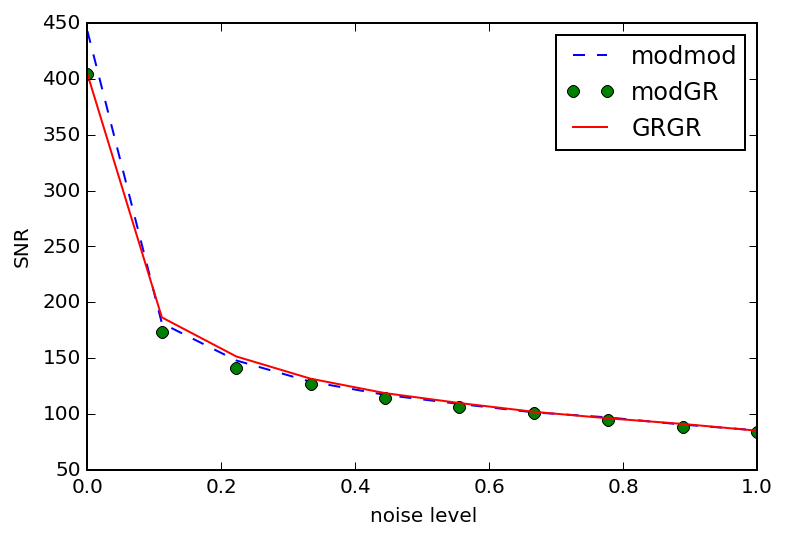

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


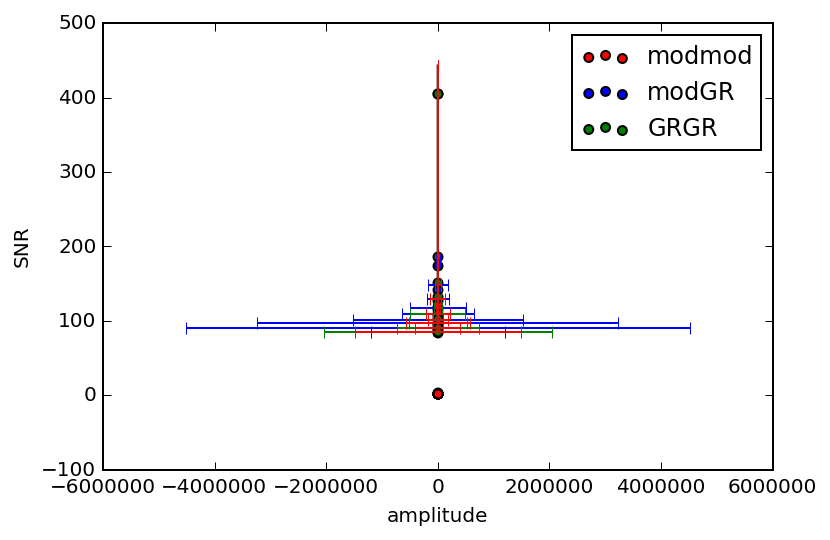

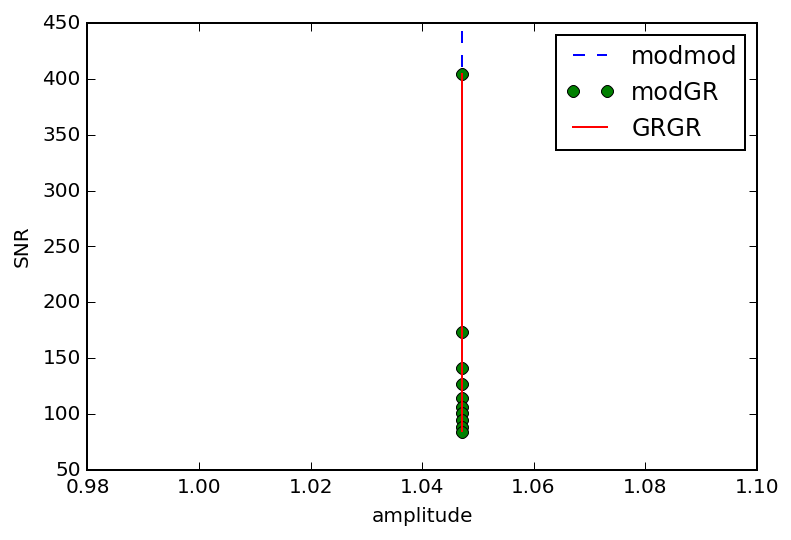

In [414]:
   
plt.plot(noise_levels,modmod_snr_arr, '--', label="modmod")
plt.plot(noise_levels,modGR_snr_arr, 'o',label="modGR")
plt.plot(noise_levels,GRGR_snr_arr, label="GRGR")
plt.xlabel("noise level")
plt.ylabel("SNR")
plt.legend(loc=0)
plt.show()

modmodr_amps_means = [np.mean(amp) for amp in modmodr_amps]
modmodr_amps_vars = [np.var(amp) for amp in modmodr_amps]
plt.scatter(modmodr_amps_means, np.log10(modmod_snr_arr),marker='o', c='r',label="modmod")
plt.errorbar(modmodr_amps_means, np.log10(modmod_snr_arr), xerr=modmodr_amps_vars)

modGRr_amps_means = [np.mean(amp) for amp in modGRr_amps]
modGRr_amps_vars = [np.var(amp) for amp in modGRr_amps]
plt.scatter(modGRr_amps_means, np.log10(modGR_snr_arr), marker='o', c='b',label="modGR")
plt.errorbar(modGRr_amps_means, np.log10(modmod_snr_arr), xerr=modGRr_amps_vars)

GRGRr_amps_means = [np.mean(amp) for amp in GRGRr_amps]
GRGRr_amps_vars = [np.var(amp) for amp in GRGRr_amps]
plt.scatter(GRGRr_amps_means, GRGR_snr_arr, marker='o', c='g',label="GRGR")
plt.errorbar(GRGRr_amps_means, modmod_snr_arr, xerr=GRGRr_amps_vars)
#plt.xlim(0,1.2)
plt.ylabel("SNR")
plt.xlabel("amplitude")
plt.legend(loc=0)
plt.show()

plt.plot([np.mean(phase) for amp in modmodr_phases], modmod_snr_arr,'--', label="modmod")
plt.plot([np.mean(phase) for amp in modGRr_phases], modGR_snr_arr, 'o',label="modGR")
plt.plot([np.mean(phase) for amp in GRGRr_phases], GRGR_snr_arr, label="GRGR")
#plt.xlim(0,1.2)
plt.ylabel("SNR")
plt.xlabel("amplitude")
plt.legend(loc=0)
plt.show()
  
# snr ~12

In [ ]:
  
# how well are they recovered? 
plt.hist(modmodr_amps,label="modmod {0}".format(np.mean(modmodr_amps)))
plt.hist(modGRr_amps,label="modGR {0}".format(np.mean(modGRr_amps)))
plt.hist(GRGRr_amps,label="GRGR {0}".format(np.mean(GRGRr_amps)))
plt.ylabel("for SNR {0}".format(GRGR_snr_arr[-1]))
plt.xlabel("recovered amplitude ratio")
plt.legend()
plt.show()


plt.hist(modmodr_phases, label="modmod {0}".format(np.mean(modmodr_amps)))
plt.hist(modGRr_phases, label="modGR {0}".format(np.mean(modGRr_phases)))
plt.hist(GRGRr_phases, label="GRGR {0}".format(np.mean(GRGRr_phases)))
plt.ylabel("for SNR {0}".format(GRGR_snr_arr[-1]))
plt.xlabel("recovered phase ratio")
plt.legend()
plt.show()
#plt.scatter(noise_levels,[np.mean(r) for r in rphase],label=template_name)
#plt.legend()
#plt.show()

#n=10
#print('for SNR', SNRmax, 'we multiply ',n,' of them together and find:')


In [97]:

data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
 '''
        print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
              .format(det,timemax,SNRmax,d_eff,horizon))

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.show()
        '''

'''
NFFT = 4*fs
Pxx_template, freqs = mlab.psd(template, Fs = fs, NFFT = NFFT)


# We will use interpolations of the ASDs computed above for whitening:
psd_template = interp1d(freqs, Pxx_template)



# function to writen data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht



# whiten the templates:
template_p_whiten = whiten(template_p,psd_template,dt)
template_c_whiten = whiten(template_c,psd_template,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten)
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten)

'''

'''
# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
#template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))


plt.figure(figsize=(10,16))
plt.subplot(4,1,1)
plt.plot(time-time[0]-template_offset,template_p)
plt.xlim([-template_offset,1.])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('strain')
plt.title(eventname+' template at D_eff = 1 Mpc')
'''


'\n# Compute, print and plot some properties of the template:\n\n# constants:\nclight = 2.99792458e8                # m/s\nG = 6.67259e-11                      # m^3/kg/s^2 \nMSol = 1.989e30                      # kg\n\n# template parameters: masses in units of MSol:\nt_mtot = t_m1+t_m2\n# final BH mass is typically 95% of the total initial mass:\nt_mfin = t_mtot*0.95\n# Final BH radius, in km:\nR_fin = 2*G*t_mfin*MSol/clight**2/1000.\n\n# complex template:\n#template = (template_p + template_c*1.j) \nttime = time-time[0]-template_offset\n\n# compute the instantaneous frequency of this chirp-like signal:\ntphase = np.unwrap(np.angle(template))\nfGW = np.gradient(tphase)*fs/(2.*np.pi)\n# fix discontinuities at the very end:\niffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]\nfGW[iffix] = fGW[iffix[0]-1]\nfGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]\n\n# compute v/c:\nvoverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)\n\n# index where f_GW is in-band:\nf_inband = fband[0]\niband = np.

For detector template, maximum at 8.0001 with SNR = 155.8, D_eff = 0.52, horizon = 10.1 Mpc


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


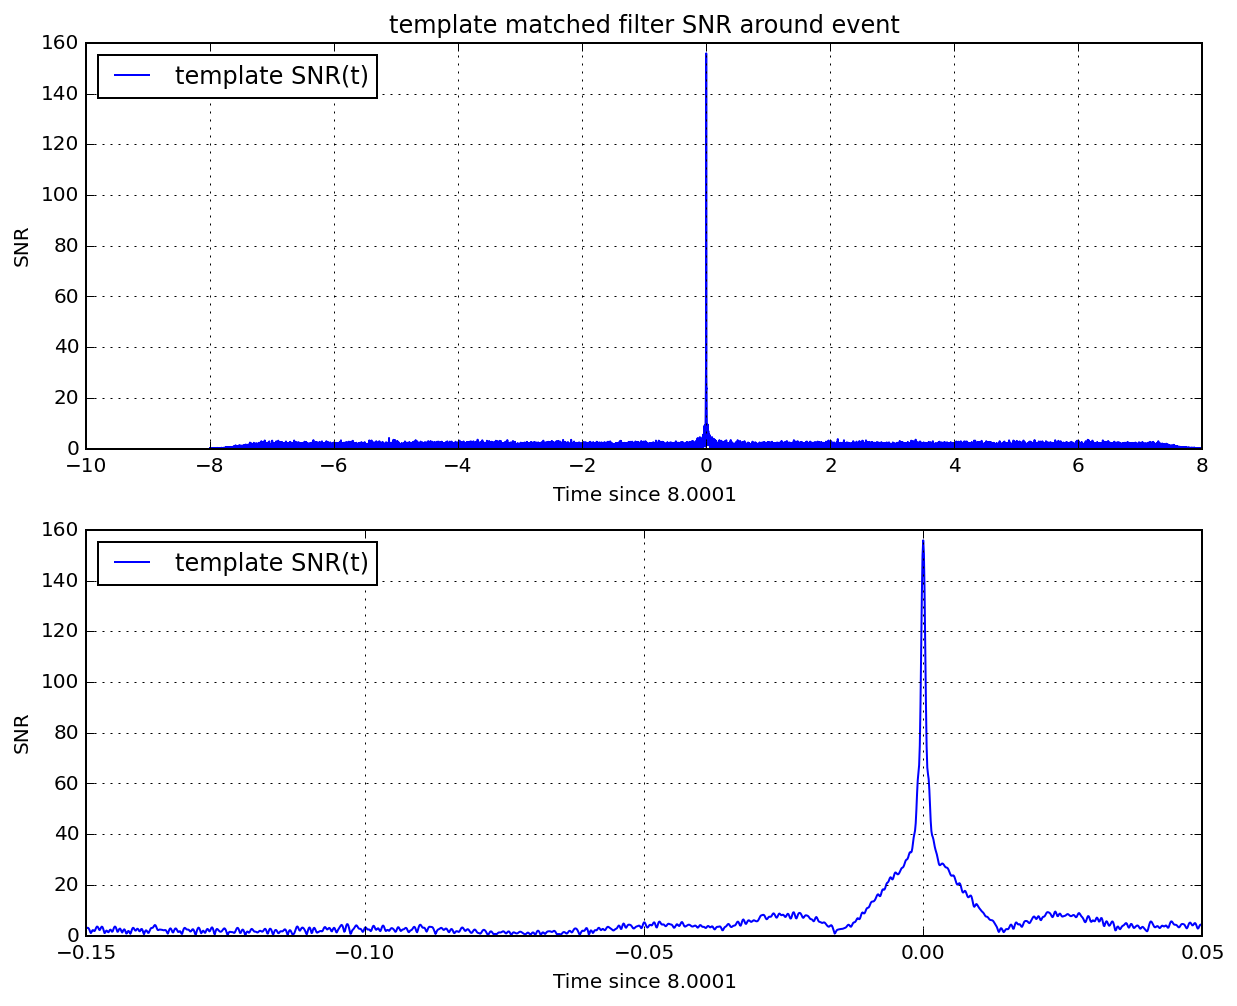

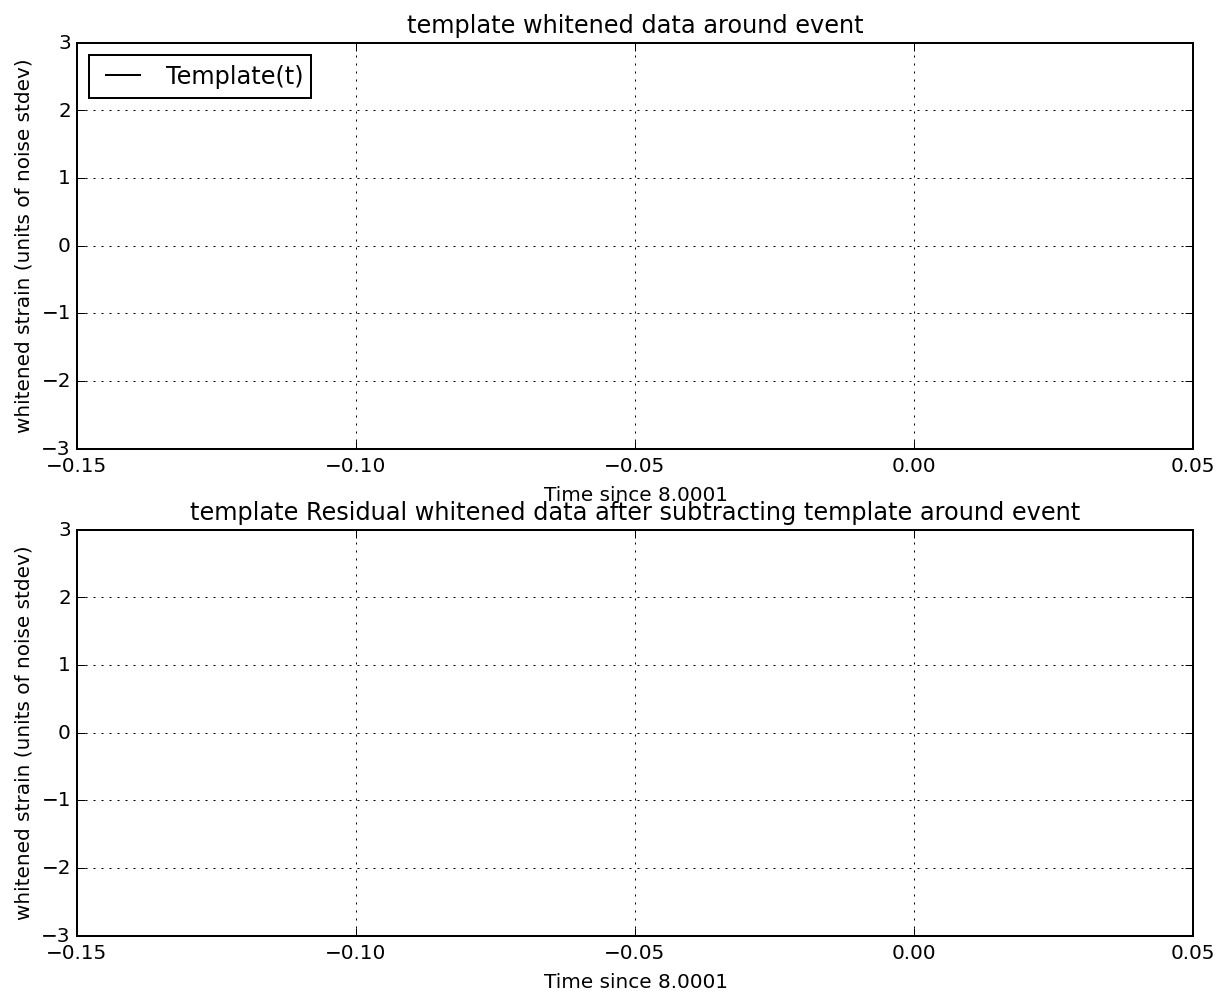

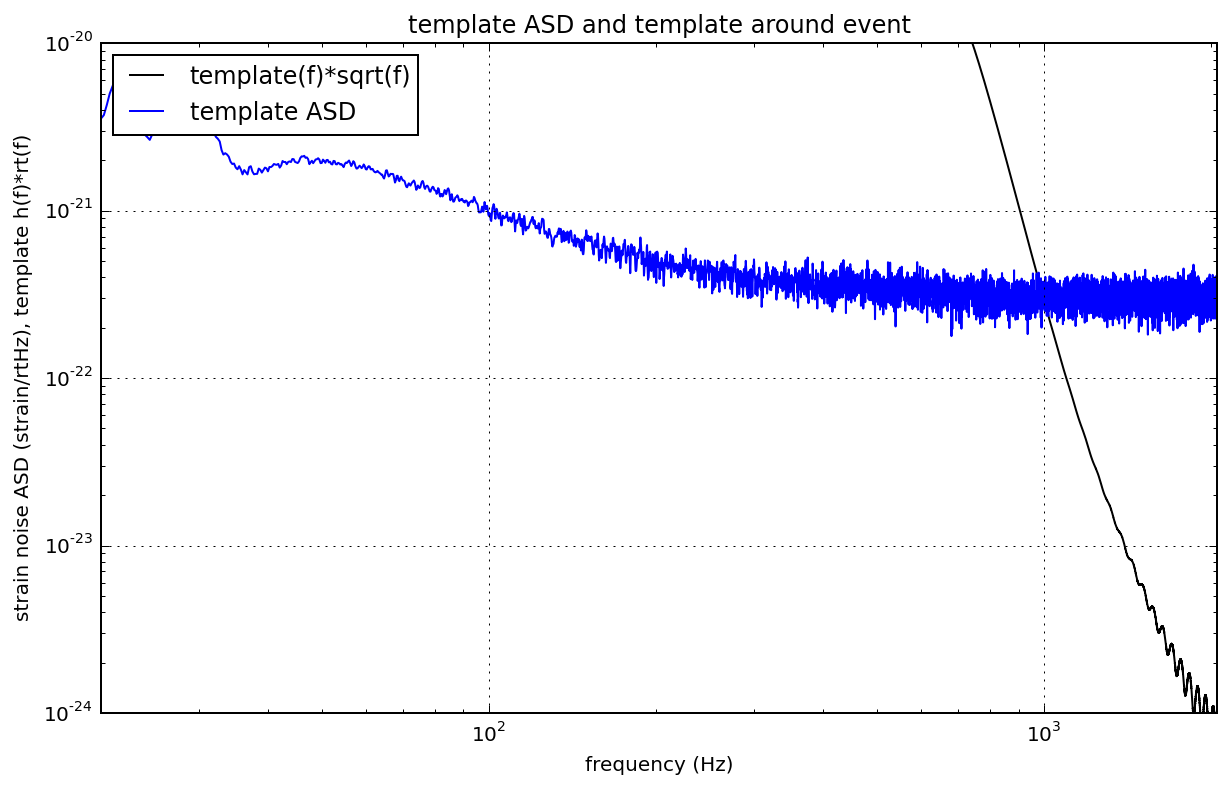

In [85]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2


# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs


# -- Calculate the PSD of the data.  Also use an overlap, and window:
data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

# Take the Fourier Transform (FFT) of the data and the template (with dwindow)
data_fft = np.fft.fft(data*dwindow) / fs

# -- Interpolate to get the PSD values at the needed frequencies
power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

# -- Calculate the matched filter output in the time domain:
# Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
# Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
# so the result will be plotted as a function of time off-set between the template and the data:
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*fs

# -- Normalize the matched filter output:
# Normalize the matched filter output so that we expect a value of 1 at times of just noise.
# Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma

# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]

# Calculate the "effective distance" (see FINDCHIRP paper for definition)
# d_eff = (8. / SNRmax)*D_thresh
d_eff = sigma / SNRmax
# -- Calculate optimal horizon distnace
horizon = sigma/8

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)
#print offset

# apply time offset, phase, and d_eff to whitened template, for plotting
#template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
template_whitened = template
template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
template_match = np.roll(template_phaseshifted,offset) / d_eff

#strain_whitenbp = filtfilt(bb, ab, whiten(strain_L1,psd_L1,dt))


det = 'template'
print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
      .format(det,timemax,SNRmax,d_eff,horizon))
# -- Plot the result
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-timemax, SNR,label=det+' SNR(t)')
#plt.ylim([0,25.])
plt.grid('on')
plt.ylabel('SNR')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')
plt.title(det+' matched filter SNR around event')

# zoom in
plt.subplot(2,1,2)
plt.plot(time-timemax, SNR,label=det+' SNR(t)')
plt.grid('on')
plt.ylabel('SNR')
plt.xlim([-0.15,0.05])
#plt.xlim([-0.3,+0.3])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.legend(loc='upper left')

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
#plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
plt.plot(time-tevent,template_match,'k',label='Template(t)')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' whitened data around event')

plt.subplot(2,1,2)
#plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
plt.ylim([-3,3])
plt.xlim([-0.15,0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(timemax))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title(det+' Residual whitened data after subtracting template around event')


# -- Display PSD and template
# must multiply by sqrt(f) to plot template fft on top of ASD:
plt.figure(figsize=(10,6))
template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
plt.loglog(freqs, np.sqrt(data_psd), label=det+' ASD')
plt.xlim(20, fs/2)
plt.ylim(1e-24, 1e-20)
plt.grid()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
plt.legend(loc='upper left')
plt.title(det+' ASD and template around event')


# References

(<a id="cit-abbott2016b" href="#call-abbott2016b">LIGO and {Abbott}, 2016</a>) LIGO {The and {Abbott} B.~P., ``_Calibration of the Advanced LIGO detectors for the discovery of the binary black-hole merger GW150914_'', ArXiv e-prints, vol. , number , pp. , February 2016.

(<a id="cit-Feedback2005" href="#call-Feedback2005">Bechhoefer, 2005</a>) Bechhoefer John, ``_Feedback for physicists: A tutorial essay on control_'', Rev. Mod. Phys., vol. 77, number , pp. 783--836, Aug 2005.  [online](http://link.aps.org/doi/10.1103/RevModPhys.77.783)

